<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARIMA</font></b></strong>

**Modelos de Média Móvel Integrada Auto-Regressiva (ARIMA - Autoregressive Integrated Moving Average Models )**

ARIMA (p, d, q) 

O ARIMA é uma extensão natural da classe de modelos ARMA, que pode reduzir uma série não estacionária a uma série estacionária usando uma sequência de diferenças.

Uma série temporal x(t) é integrada na ordem d se diferenciar a série "d vezes", resultar em uma série discreta de ruído branco.

Uma série temporal x(t) é o modelo ARIMA (p, d, q) se a série diferir d vezes e, em seguida, seguir um processo ARMA (p, q).

Vamos simular um modelo ARIMA para nosso problema de negócio e verificar se conseguimos uma performance melhor do que tivemos com o modelo ARMA.

AR: indica que a variável é regressada em seus valores

I: indica que os valores de dados foram substituídos com a diferença entre os valores anteriores (diferenciação).

MA: Indica que o erro de regressão é uma combinação linear dos termos de erro dos valores passados.


p = ordem da autorregressão

d = grau da diferenciação

q = ordem da média móvel

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
#plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from time import time
from datetime import datetime
from datetime import date, timedelta

#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy      : 1.19.5
statsmodels: 0.12.2
matplotlib : 3.3.4
scipy      : 1.6.2
sys        : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
sklearn    : 1.1.1
pandas     : 1.2.4



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-10-26 to 2022-10-25
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Quantidade  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [5]:
# Dados
dataframe.head()

Quantidade
Data                  
2021-10-26       162.0
2021-10-27        66.0
2021-10-28        58.0
2021-10-29        44.0
2021-10-30        83.0

In [6]:
type(dataframe.index)

pandas.core.indexes.datetimes.DatetimeIndex

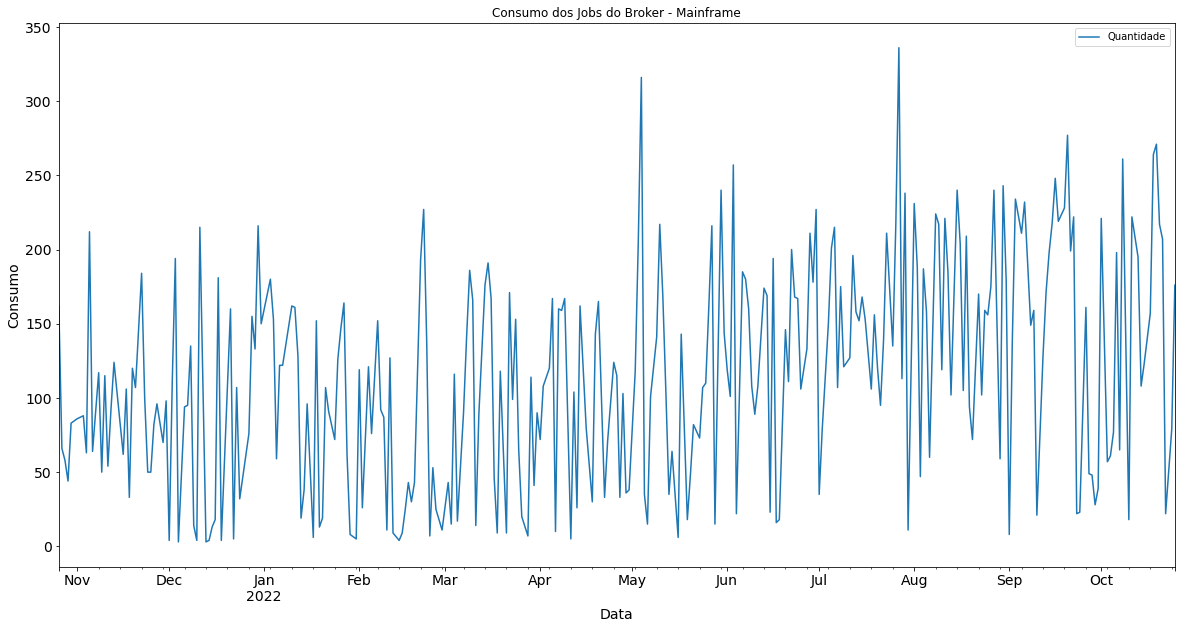

In [7]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [8]:
# teste de performance para ver qual é o melhor número de lags para a média móvel

optimal_n = None

best_mse = None

db = dataframe[['Quantidade']].values.astype('float32')

mean_results_for_all_possible_n_values = np.zeros(int(len(db) / 2 - 2))


for n in range(3, int(len(db) / 2 + 1)):
    mean_for_n = np.zeros(len(db) - n)
    for i in range(0, len(db) - n):
        mean_for_n[i] = np.power(np.mean(db[:, 0][i:i+n]) - db[i + n][0], 2)
    mean_results_for_all_possible_n_values[n - 3] = np.mean(mean_for_n)
optimal_n = np.argmin(mean_results_for_all_possible_n_values) + 3
best_mse = np.min(mean_results_for_all_possible_n_values)


print("MSE = %s" % mean_results_for_all_possible_n_values)
print("Melhor MSE = %s" % best_mse)
print("Otimo n = %s" % optimal_n)

MSE = [5068.04799499 4917.44948391 4832.57116489 4680.66743919 4601.28609977
 4656.47249714 4648.29208504 4618.1796099  4610.80606949 4592.53503777
 4544.56260067 4493.46466427 4485.48570937 4456.10474853 4446.54376082
 4490.91705222 4492.9429392  4481.10310106 4490.61891631 4483.9428028
 4480.45540893 4501.98034094 4517.54216914 4493.07714509 4468.41292426
 4444.40871792 4417.65565054 4399.14375945 4406.86223299 4417.85519878
 4432.78520515 4448.76752622 4439.62652808 4445.48228711 4450.15094925
 4489.72363942 4484.82035394 4480.19878219 4470.50696831 4461.04938591
 4456.78035303 4485.19356336 4500.957051   4490.03759362 4460.83989726
 4482.27877274 4460.98055348 4445.99417169 4441.08734272 4441.02776
 4434.54324841 4431.02284913 4428.68004725 4423.55408763 4411.85474958
 4413.71459437 4441.95717404 4461.40524106 4480.51457958 4492.94108679
 4496.3396505  4499.50019551 4508.18889129 4465.68045695 4474.41203163
 4485.88777018 4486.56346476 4474.20414417 4466.48086736 4475.56797586
 449

In [9]:
# Média móvel de 30 dias - (ótimo n = 30 anterior)

rolmean = dataframe.rolling(window = 30).mean()

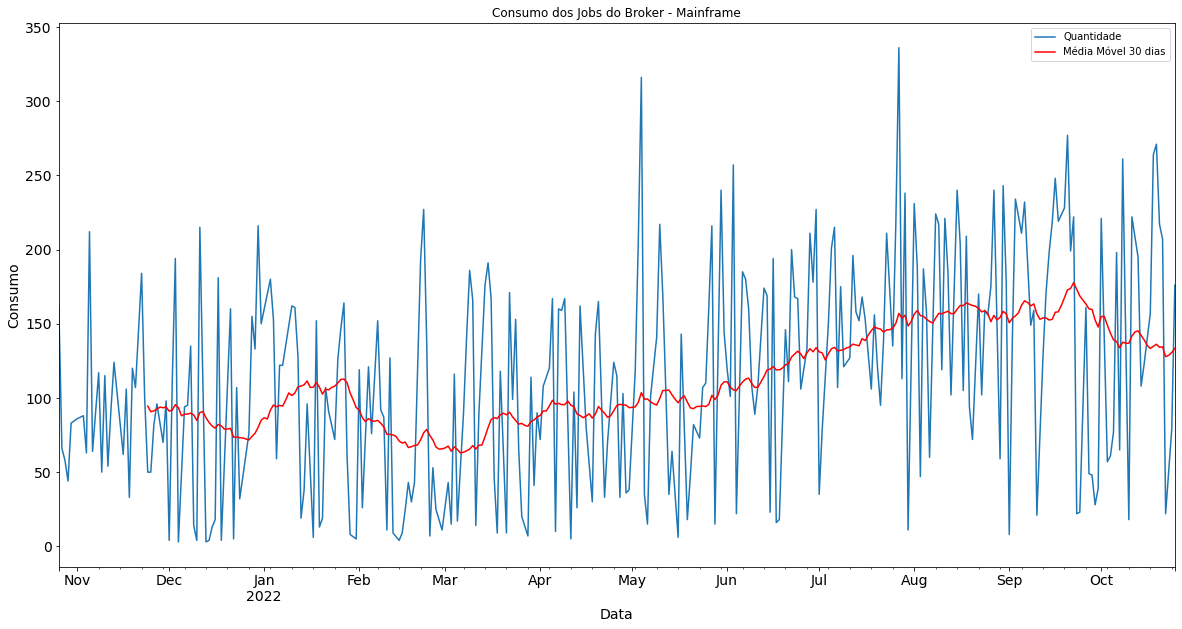

In [10]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.plot(rolmean, label = 'Média Móvel 30 dias', color = 'red')
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [11]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['Quantidade']

p: ordem da parte autoregressiva - PACF

d: grau de diferenciação - Teste de Estacionariedade

q: ordem da média móvel - ACF

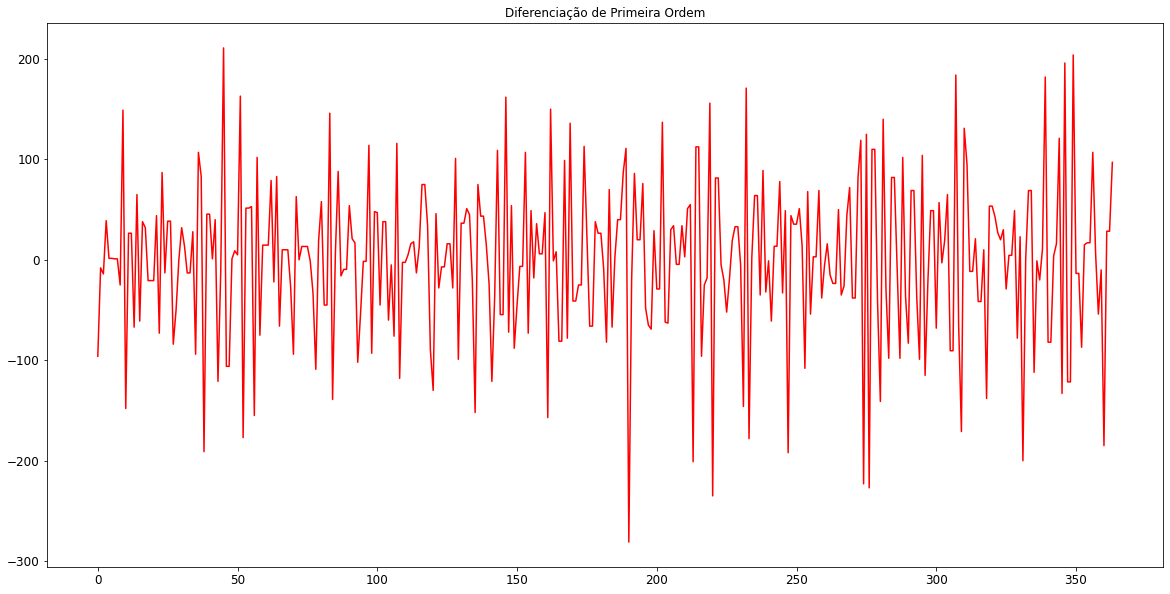

In [12]:
# Gráfico PACF
plt.plot(np.diff(target.values), color = 'red'); 
plt.title('Diferenciação de Primeira Ordem')
plt.show()

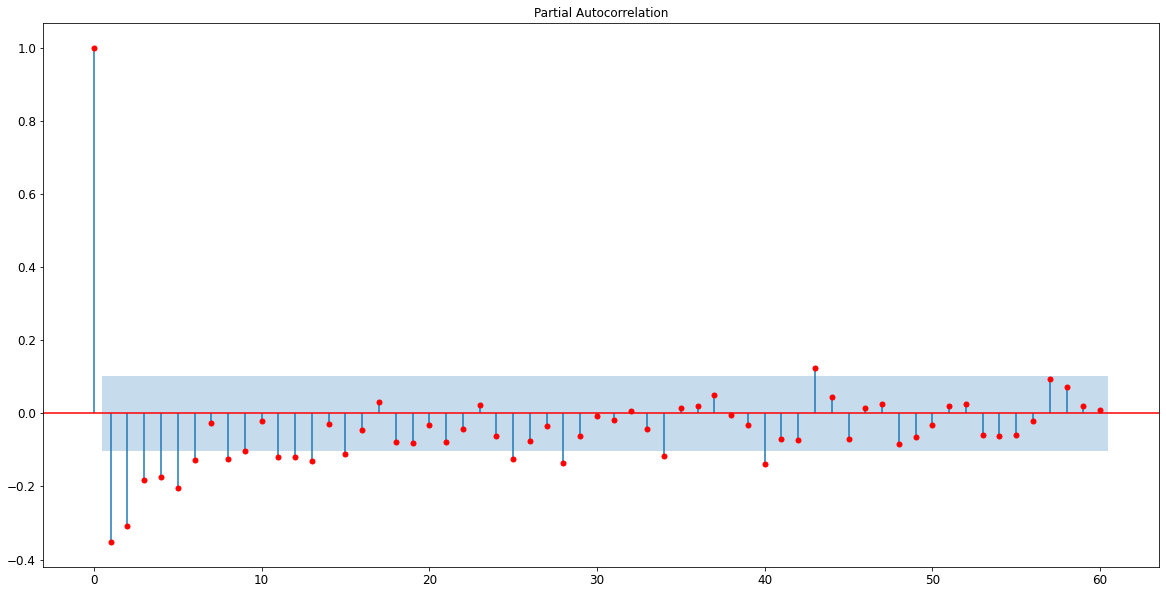

In [13]:
# Gráfico PACF
plot_pacf(np.diff(target.values), lags = 60, color = 'red')
plt.show()

p = 0

ARIMA (p, d, q) = (0, d, q)

In [14]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 10).mean()
    rolstd = serie.rolling(window = 10).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

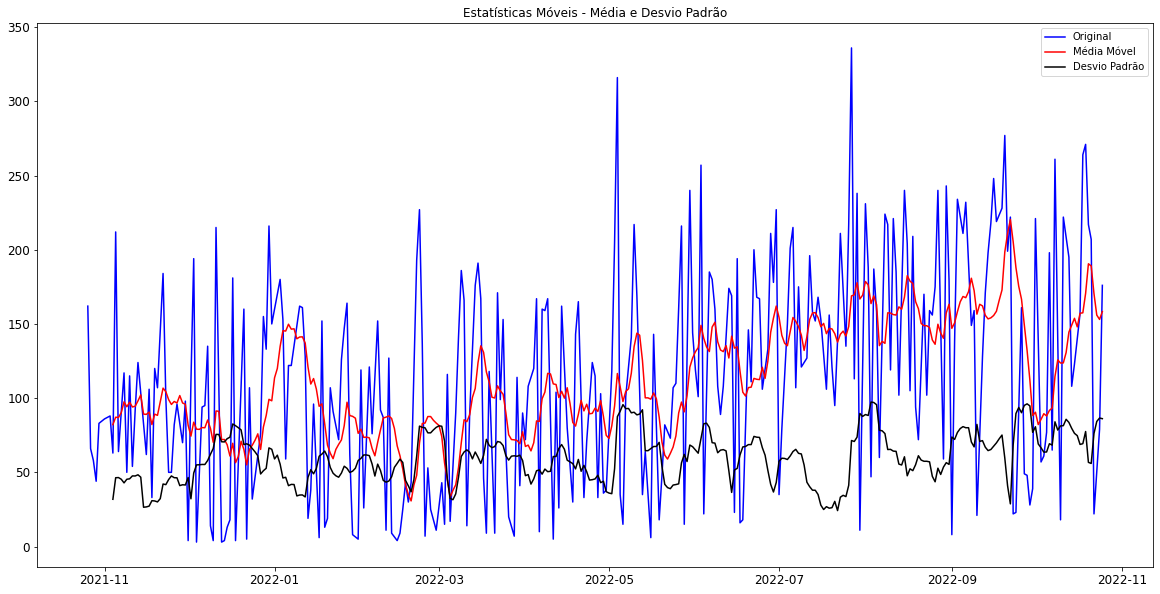


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -5.155394
Valor-p                           0.000011
Número de Lags Consideradas       5.000000
Número de Observações Usadas    359.000000
Valor Crítico (1%)               -3.448697
Valor Crítico (5%)               -2.869625
Valor Crítico (10%)              -2.571077
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [15]:
# Aplica a função 
testa_estacionaridade(dataframe['Quantidade'])

In [16]:
# Teste ADF
resultado = adfuller(target)
print('Estatística ADF: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

Estatística ADF: -5.155394
Valor-p: 0.000011


O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd' pelo Modelo ARIMA.

A a série temporal é estacionária.

In [17]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [18]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

Ou seja, o Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

Vamos escolher d = 1 pois vimos no gráfico a diferença quando aplicamos a primeira diferenciação. 

d = 1

ARIMA (p, d, q) = (0, 1, q)

q: ordem da média móvel - ACF

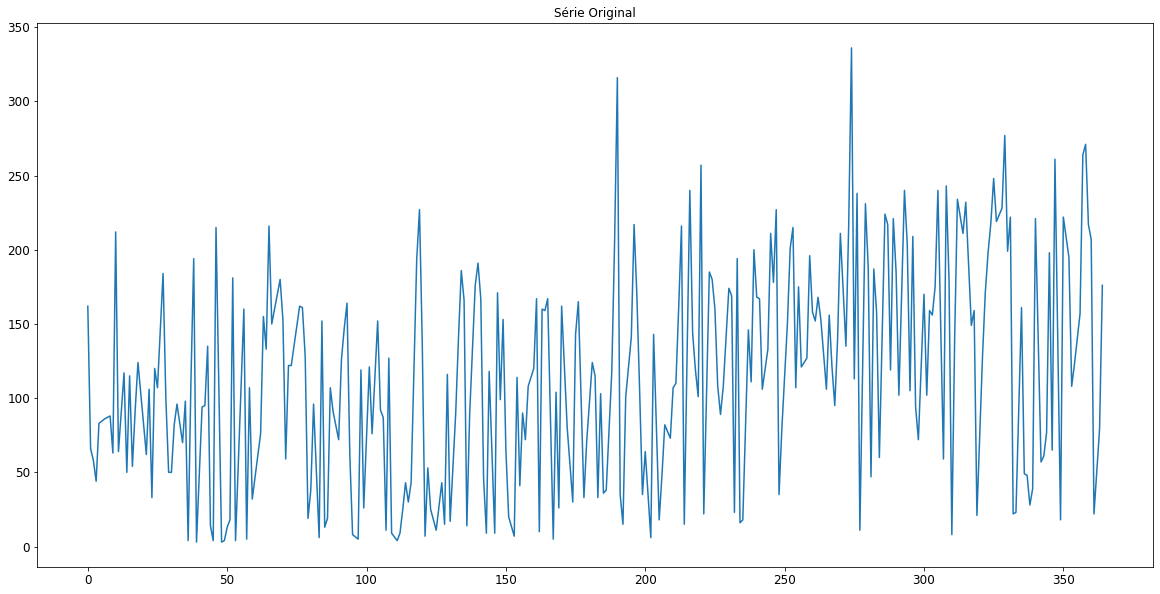

In [19]:
# Gráfico ACF
plt.plot(target.values)
plt.title('Série Original')
plt.show()

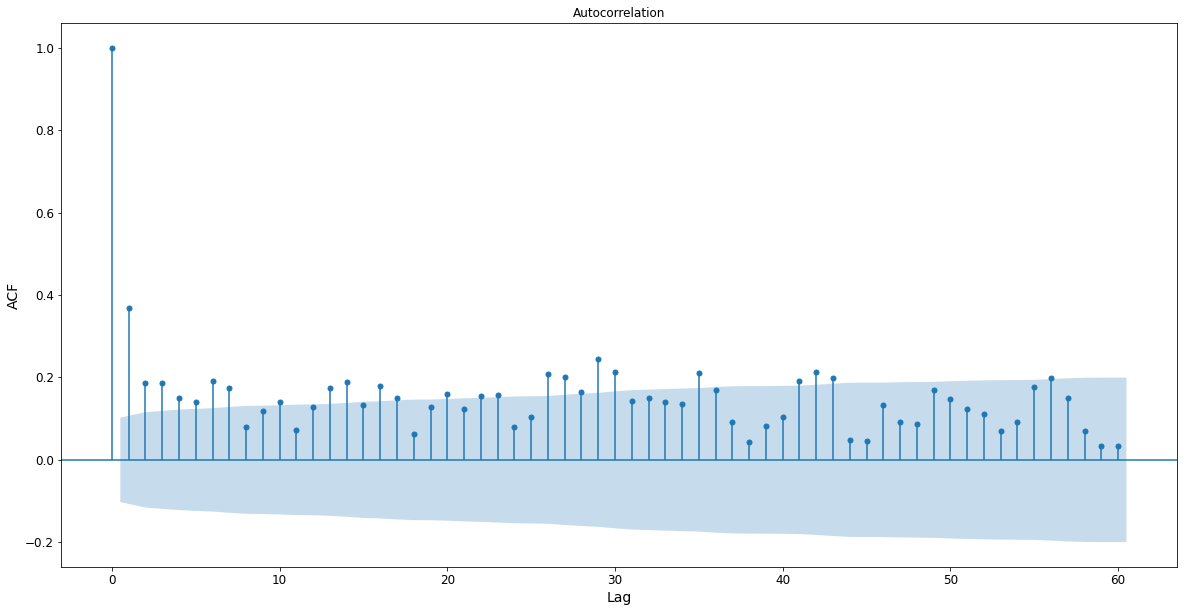

In [20]:
plot_acf(target,lags=60)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

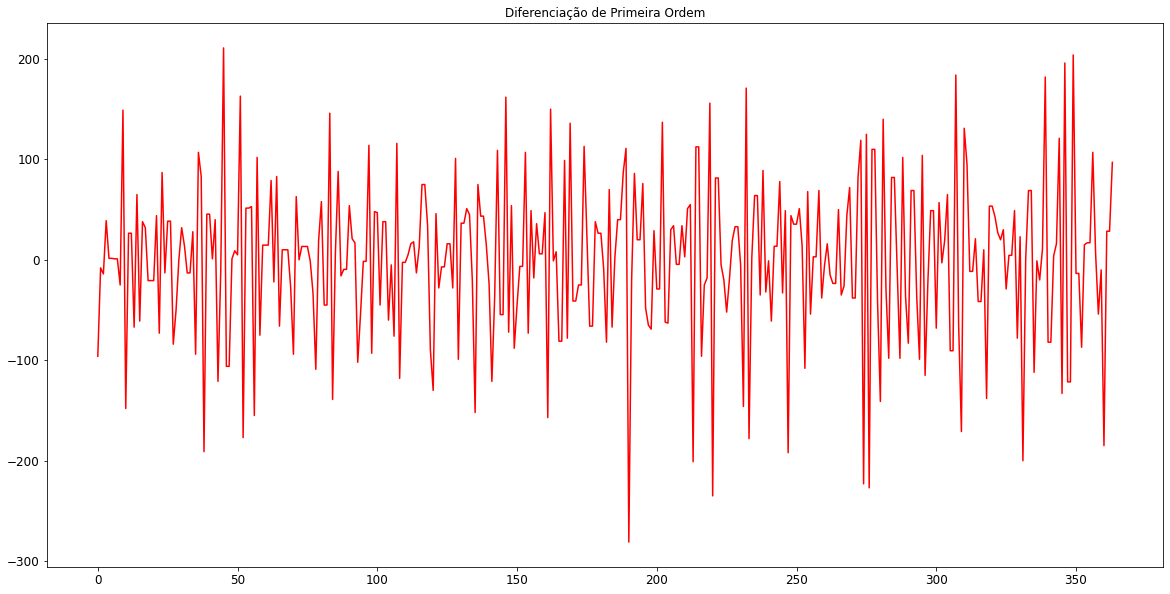

In [21]:
# Gráfico ACF
plt.plot(np.diff(target.values), color = 'red')
plt.title('Diferenciação de Primeira Ordem')
plt.show()

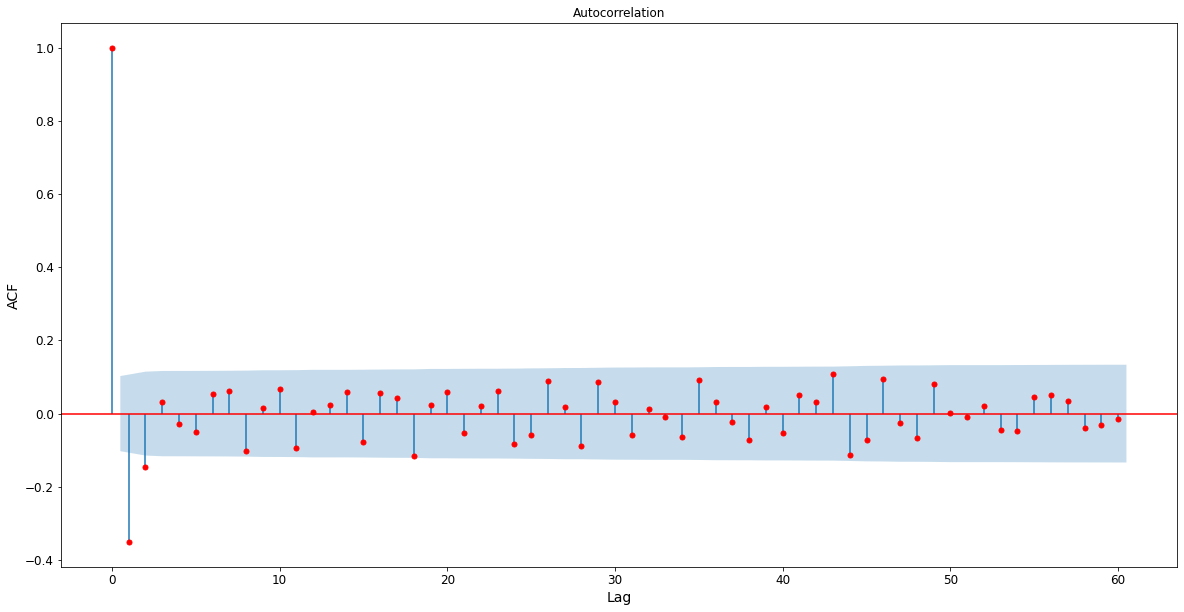

In [22]:
plot_acf(np.diff(target.values),lags=60, color = 'red')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

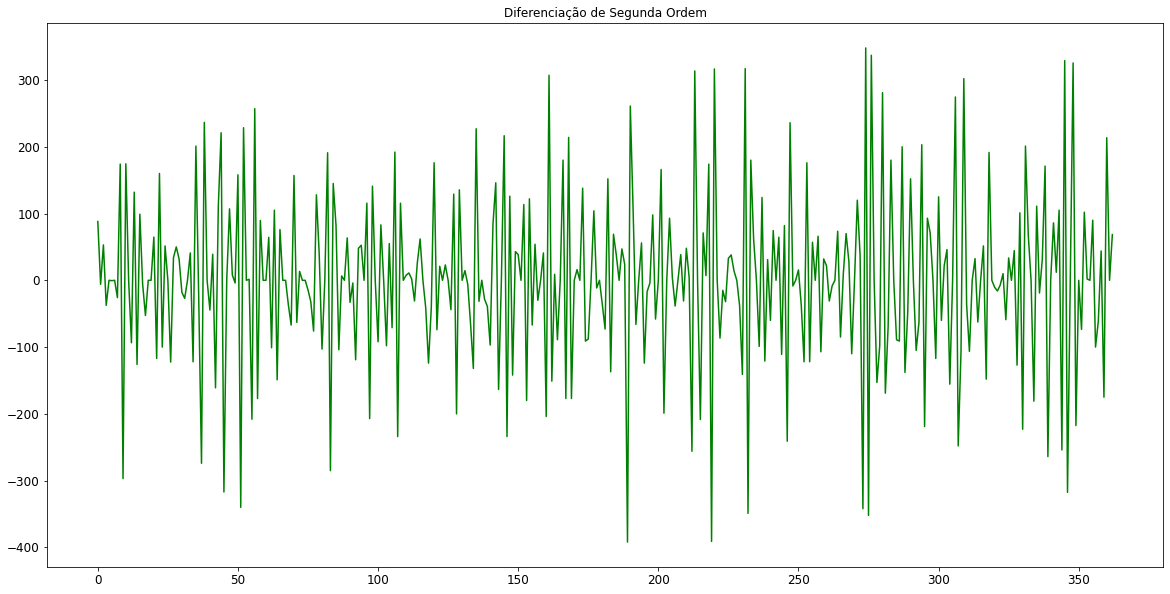

In [23]:
# Gráfico ACF
plt.plot(np.diff(np.diff(target.values)), color = 'green') 
plt.title('Diferenciação de Segunda Ordem')
plt.show()

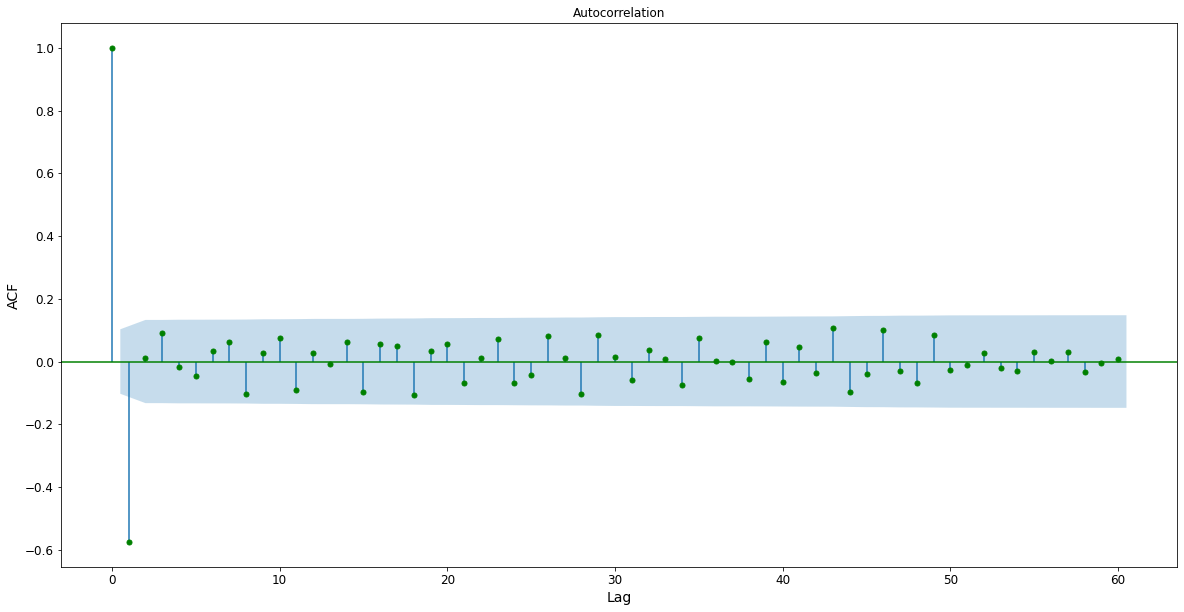

In [24]:
plot_acf(np.diff(np.diff(target.values)),lags=60, color = 'green')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

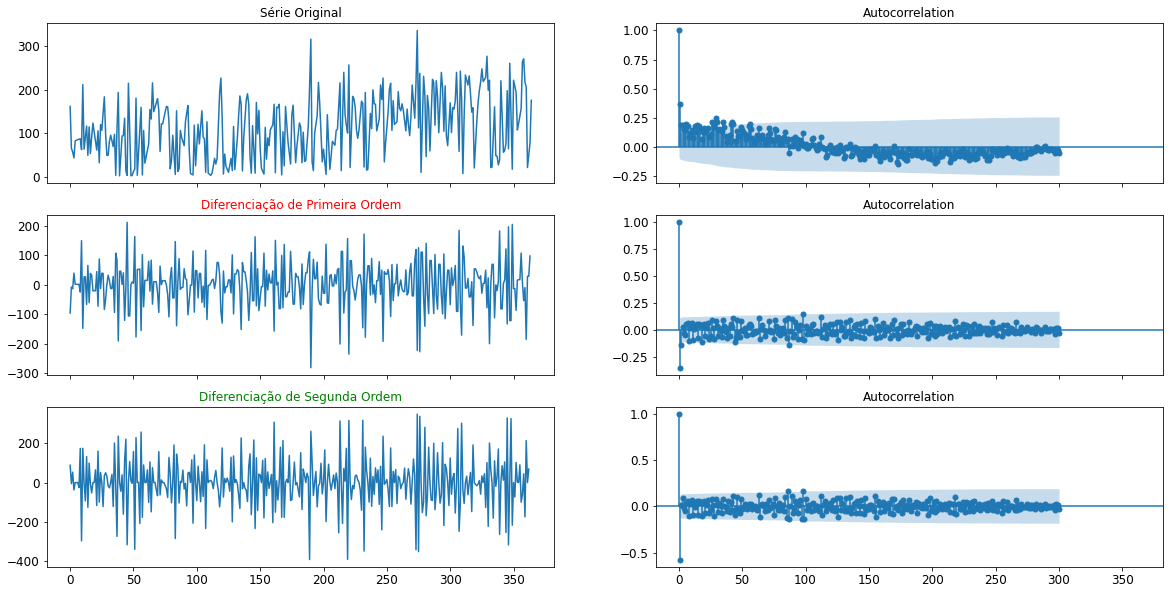

In [25]:
# Área de Plotagem
fig, axes = plt.subplots(3, 2, sharex = True)

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 300, ax = axes[0, 1])

# Diferenciação de Primeira Ordem
axes[1, 0].plot(np.diff(target.values)); axes[1, 0].set_title('Diferenciação de Primeira Ordem', color = 'RED')
plot_acf(np.diff(target.values), lags = 300, ax = axes[1, 1])

# Diferenciação de Segunda Ordem
axes[2, 0].plot(np.diff(np.diff(target.values))); axes[2, 0].set_title('Diferenciação de Segunda Ordem', color = 'green')
plot_acf(np.diff(np.diff(target.values)), lags = 300, ax = axes[2, 1])

plt.show()

q = 1

ARIMA (p, d, q) = (0, 1, 1)

In [26]:
# Decompondo a série temporal
decomposition = seasonal_decompose(dataframe['Quantidade'])

In [27]:
# Extraindo cada componente da série
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

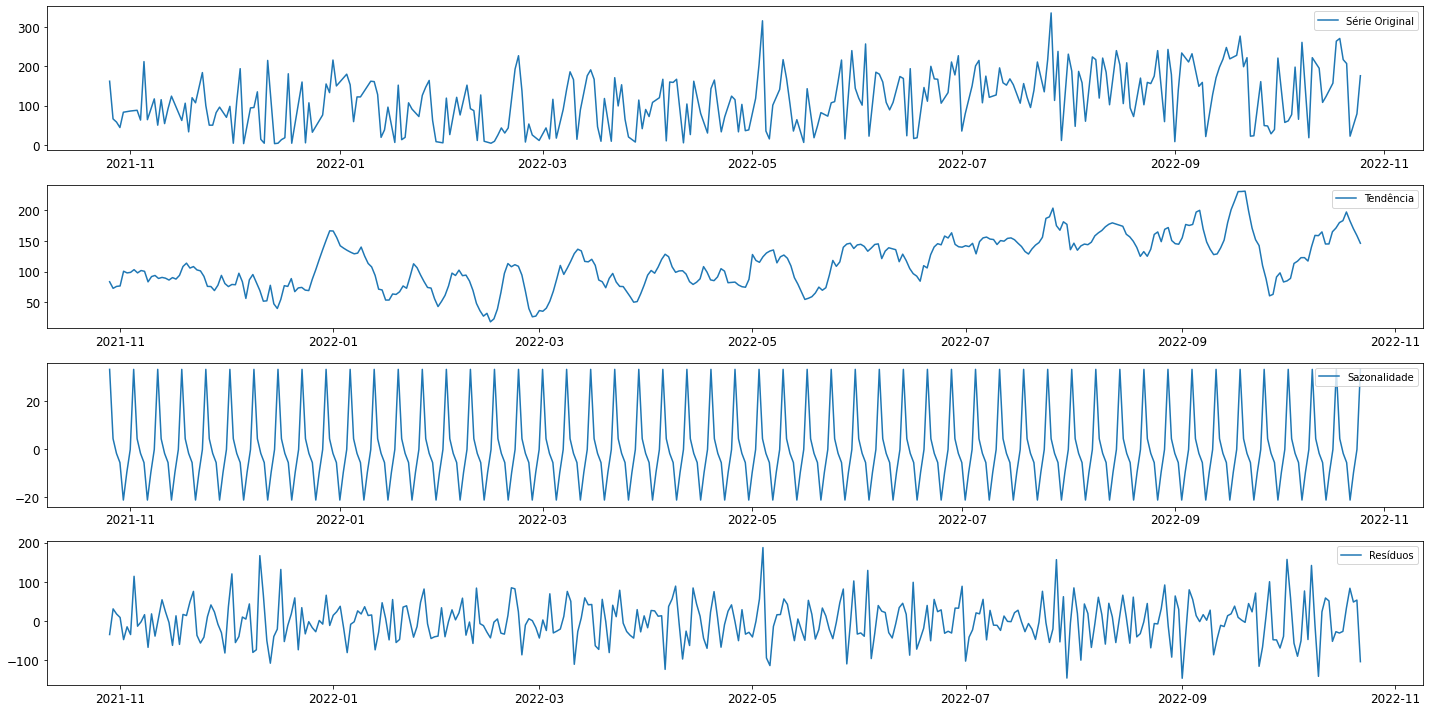

In [28]:
# Plot
plt.subplot(411)
plt.plot(dataframe['Quantidade'], label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

In [29]:
# Random seed 
np.random.seed(7)

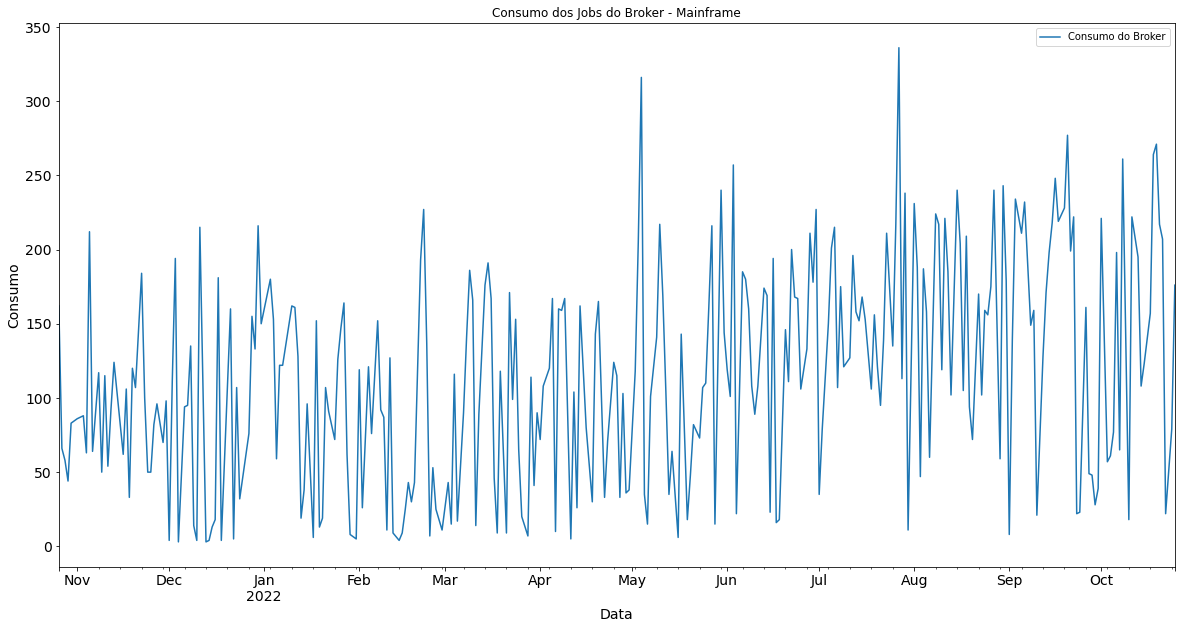

In [30]:
# Plot
target.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [31]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

273 92


In [32]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [33]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [34]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [35]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

O Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

A escolha é sua meu caro(a) Cientista de Dados.

In [36]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARIMA

Antes de criar o modelo ARIMA, vamos aplicar o conceito de Grid Search para encontrar a melhor combinação de valores para os parâmetros p, d e q.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

### Grid Search Para os Parâmetros p, d e q

In [37]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(method = 'mle', disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
      
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions)
    return error

In [38]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = avalia_modelo_arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s   MSE = %.4f   RMSE = %.4f'% (order, mse, np.sqrt(mse)))
                except:
                    continue

    print('\nMelhor Modelo ARIMA%s   MSE = %.4f   RMSE = %.4f' % (best_cfg, best_score, np.sqrt(best_score)))

In [39]:
# Valores para o grid
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1] 
q_values = [0, 1, 2, 3, 4, 5] 

In [40]:
# Testando o melhor valor de p, d e q em os dados de treino

start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

warnings.simplefilter("ignore")

avalia_melhor_arima(treino.values, p_values, d_values, q_values)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 09:24:36
ARIMA(0, 0, 0)   MSE = 4596.5798   RMSE = 67.7981
ARIMA(0, 0, 1)   MSE = 4119.2255   RMSE = 64.1812
ARIMA(0, 0, 2)   MSE = 4062.5058   RMSE = 63.7378
ARIMA(0, 0, 3)   MSE = 4024.8420   RMSE = 63.4416
ARIMA(0, 0, 4)   MSE = 4152.4227   RMSE = 64.4393
ARIMA(0, 0, 5)   MSE = 4168.4787   RMSE = 64.5638
ARIMA(0, 1, 0)   MSE = 5696.0925   RMSE = 75.4725
ARIMA(0, 1, 1)   MSE = 3406.4030   RMSE = 58.3644
ARIMA(0, 1, 2)   MSE = 3479.0179   RMSE = 58.9832
ARIMA(0, 1, 3)   MSE = 3522.4033   RMSE = 59.3498
ARIMA(0, 1, 4)   MSE = 3542.3418   RMSE = 59.5176
ARIMA(0, 1, 5)   MSE = 3650.3771   RMSE = 60.4184
ARIMA(1, 0, 0)   MSE = 3980.1660   RMSE = 63.0886
ARIMA(1, 0, 1)   MSE = 4008.7517   RMSE = 63.3147
ARIMA(1, 0, 2)   MSE = 3736.3308   RMSE = 61.1255
ARIMA(1, 1, 0)   MSE = 4708.5750   RMSE = 68.6191
ARIMA(1, 1, 1)   MSE = 3496.7849   RMSE = 59.1336
ARIMA(1, 1, 2)   MSE = 3525.6701   RMSE = 59.3774
ARIMA(1, 1, 3)   MSE = 3518.4040   RMSE = 59.3161
ARIMA(1, 1, 4)   MSE = 3

As mensagens de warning acima indicam que as algumas combinações testadas não fazem o modelo nem mesmo convergir.

De acordo com o resultado, os melhores valores são: order = (0, 1, 1). 

## Vamos fazer previsões com o modelo Forecast usando 'ARIMA'

In [200]:
# Modelo
#modelo_AR = ARIMA(treino, order = (0, 1, 1))
#modelo_AR = ARIMA(treino, order = (1, 1, 1))
#modelo_AR = ARIMA(treino, order = (6, 1, 1))
#modelo_AR = ARIMA(treino, order = (20, 1, 1))
#modelo_AR = ARIMA(treino, order = (15, 1, 1))
#modelo_AR = ARIMA(treino, order = (15, 0, 7))
modelo_AR = ARIMA(treino, order = (15, 1, 1))

In [201]:
# Treinamento
#modelo_v1 = modelo_AR.fit(disp = -1)  
modelo_v1 = modelo_AR.fit(method = 'mle', disp = False)

In [174]:
# ARIMA(1, 1, 1) - AIC 2990.966
# ARIMA(6, 1, 1) - AIC 2999.699
# ARIMA(20, 1, 1) - AIC 3014.397
# ARIMA(15, 1, 1) - AIC 3008.623
# ARIMA(15, 0, 7) - AIC 3014.661

In [202]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Quantidade   No. Observations:                  272
Model:                ARIMA(15, 1, 1)   Log Likelihood               -1486.312
Method:                           mle   S.D. of innovations             56.833
Date:                Tue, 01 Nov 2022   AIC                           3008.623
Time:                        11:42:07   BIC                           3073.528
Sample:                    10-27-2021   HQIC                          3034.680
                         - 07-25-2022                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2113      0.150      1.404      0.160      -0.084       0.506
ar.L1.D.Quantidade      0.2413      0.066      3.672      0.000       0.112       0.370
ar.L2.D.Quantidade     -0.0209      0.065     -0.322      0.747      -0.148       0.106
ar.L3.D.Quantidade      0.0100      0.065      0.154      0.878      -0.117       0.137
ar.L4.D.Quantidade     -0.0418      0.064     -0.650      0.516      -0.168       0.084
ar.L5.D.Quantidade      0.0147      0.064      0.230      0.818      -0.110       0.140
ar.L6.D.Quantidade      0.0514      0.063      0.810      0.418      -0.073       0.176
ar.L7.D.Quantidade      0.0023      0.063      0.037      0.970      -0.121       0.125
ar.L8.D.Quantidade     -0.0530      0.063     -0.847      0.397      -0.175       0.070
ar.L9.D.Quantidade      0.0107      0.063      0.171      0.864      -0.112       0.134
ar.L10.D.Quantidade    -0.0027      0.063     -0.043      0.966      -0.126       0.120
ar.L11.D.Quantidade    -0.0889      0.063     -1.410      0.159      -0.213       0.035
ar.L12.D.Quantidade    -0.0351      0.064     -0.552      0.581      -0.160       0.090
ar.L13.D.Quantidade    -0.0154      0.064     -0.242      0.809      -0.140       0.109
ar.L14.D.Quantidade     0.1443      0.063      2.273      0.023       0.020       0.269
ar.L15.D.Quantidade    -0.0469      0.062     -0.753      0.451      -0.169       0.075
ma.L1.D.Quantidade     -0.9682      0.027    -35.604      0.000      -1.021      -0.915
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1385           -0.0000j            1.1385           -0.5000
AR.2            -1.0166           -0.5056j            1.1354           -0.4265
AR.3            -1.0166           +0.5056j            1.1354            0.4265
AR.4            -0.7129           -0.9165j            1.1611           -0.3552
AR.5            -0.7129           +0.9165j            1.1611            0.3552
AR.6            -0.3027           -1.0971j            1.1381           -0.2928
AR.7            -0.3027           +1.0971j            1.1381            0.2928
AR.8             0.2617           -1.0903j            1.1213           -0.2125
AR.9             0.2617           +1.0903j            1.1213            0.2125
AR.10            0.7117           -0.8651j            1.1203           -0.1404
AR.11            0.7117           +0.8651j            1.1203            0.1404
AR.12            1.1080           -0.4310j            1.1889           -0.0590
AR.13            1.1080           +0.4310j            1.1889            0.0590
AR.14            1.3476           -0.0000j            1.3476           -0.0000
AR.15            2.7679           -0.0000j            2.767

In [203]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste), alpha = 0.05) 

# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste.index)
limite_inferior = pd.Series(conf[:, 0], index = teste.index)
limite_superior = pd.Series(conf[:, 1], index = teste.index)

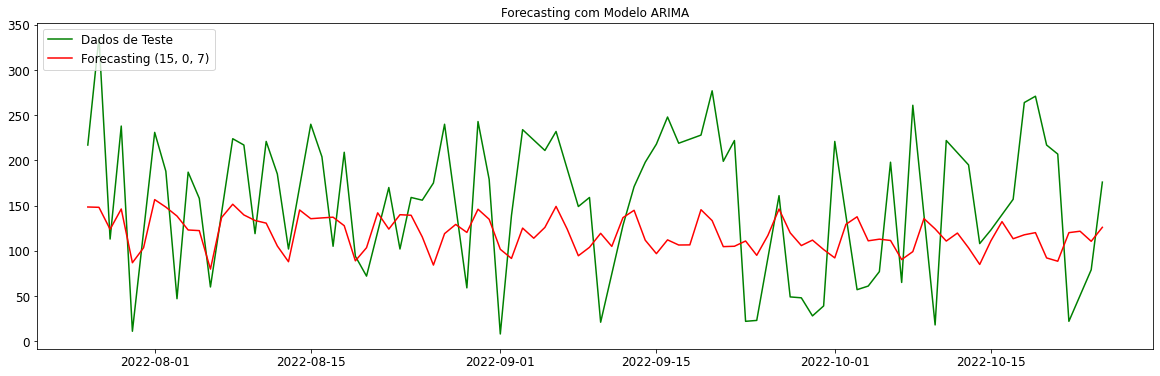

In [190]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (15, 0, 7)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

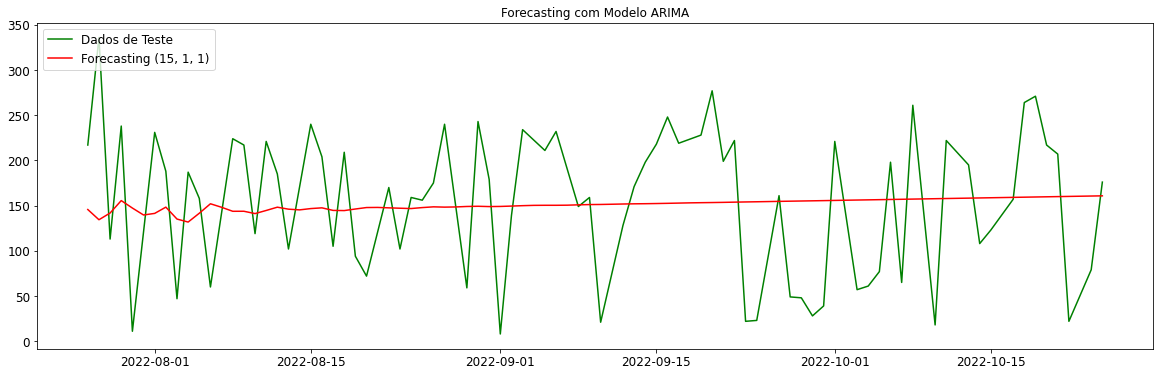

In [204]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (15, 1, 1)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

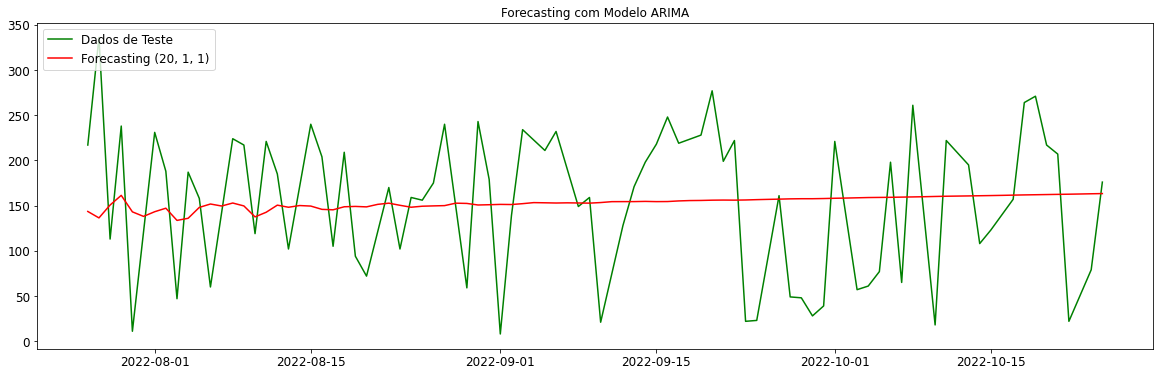

In [114]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (20, 1, 1)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

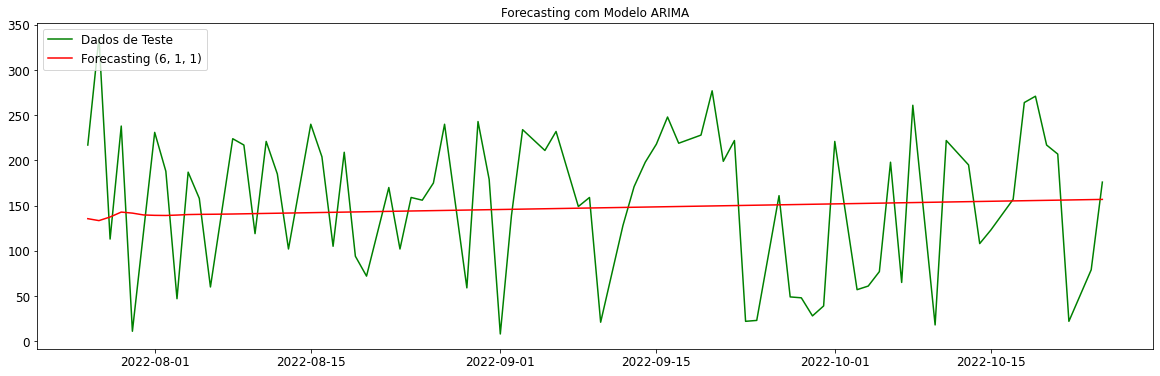

In [90]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (6, 1, 1)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

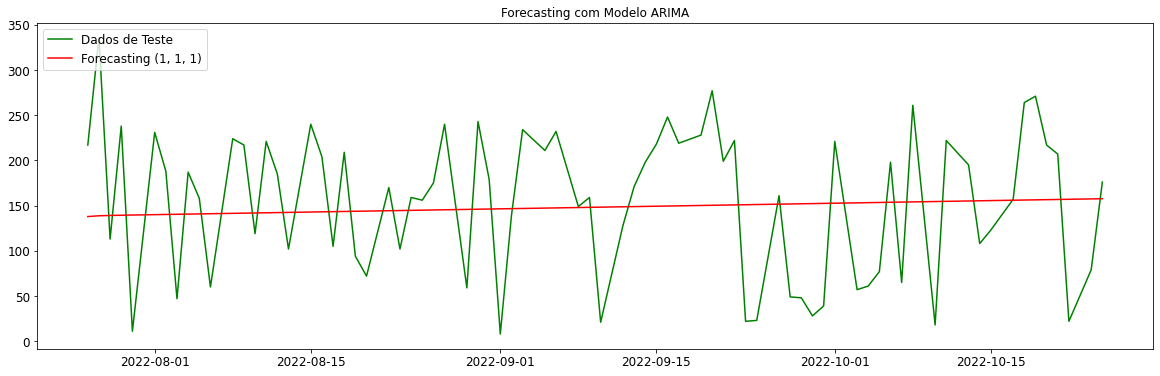

In [71]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (1, 1, 1)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

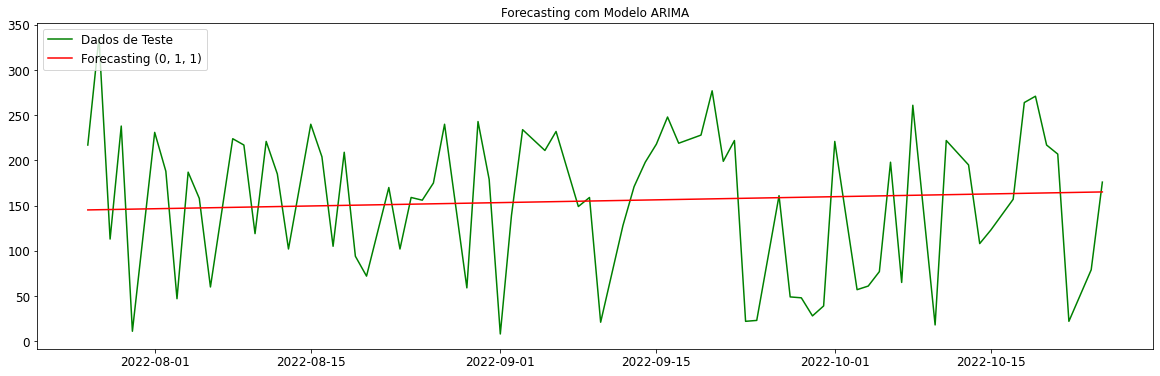

In [45]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (0, 1, 1)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [179]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 6390.653
RMSE das previsões é 79.9416
MAPE das previsões é 87.7052


In [205]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 5885.0903
RMSE das previsões é 76.7143
MAPE das previsões é 117.6524


In [115]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 5847.4113
RMSE das previsões é 76.4684
MAPE das previsões é 118.4723


In [91]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 5913.4998
RMSE das previsões é 76.8993
MAPE das previsões é 115.0101


In [72]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 5884.4493
RMSE das previsões é 76.7102
MAPE das previsões é 115.2146


In [46]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 5872.4149
RMSE das previsões é 76.6317
MAPE das previsões é 120.1356


## Vamos fazer previsões com o modelo usando 'ARIMA'

In [206]:
# Cria o modelo com os dados de treino
#modelo_arima = ARIMA(treino, order = (0, 1, 1))
#modelo_arima = ARIMA(treino, order = (1, 1, 1))
#modelo_arima = ARIMA(treino, order = (6, 1, 1))
#modelo_arima = ARIMA(treino, order = (20, 1, 1))
#modelo_arima = ARIMA(treino, order = (15, 1, 1))
modelo_arima = ARIMA(treino, order = (15, 0, 7))

In [207]:
# Treina o modelo
#modelo_arima_fit = modelo_arima.fit(disp = -1)  
modelo_arima_fit = modelo_arima.fit(method = 'mle', disp = False)

In [208]:
# Sumário do modelo
modelo_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Quantidade   No. Observations:                  272
Model:                ARIMA(15, 1, 1)   Log Likelihood               -1486.312
Method:                           mle   S.D. of innovations             56.833
Date:                Tue, 01 Nov 2022   AIC                           3008.623
Time:                        11:43:08   BIC                           3073.528
Sample:                    10-27-2021   HQIC                          3034.680
                         - 07-25-2022                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2113      0.150      1.404      0.160      -0.084       0.506
ar.L1.D.Quantidade      0.2413      0.066      3.672      0.000       0.112       0.370
ar.L2.D.Quantidade     -0.0209      0.065     -0.322      0.747      -0.148       0.106
ar.L3.D.Quantidade      0.0100      0.065      0.154      0.878      -0.117       0.137
ar.L4.D.Quantidade     -0.0418      0.064     -0.650      0.516      -0.168       0.084
ar.L5.D.Quantidade      0.0147      0.064      0.230      0.818      -0.110       0.140
ar.L6.D.Quantidade      0.0514      0.063      0.810      0.418      -0.073       0.176
ar.L7.D.Quantidade      0.0023      0.063      0.037      0.970      -0.121       0.125
ar.L8.D.Quantidade     -0.0530      0.063     -0.847      0.397      -0.175       0.070
ar.L9.D.Quantidade      0.0107      0.063      0.171      0.864      -0.112       0.134
ar.L10.D.Quantidade    -0.0027      0.063     -0.043      0.966      -0.126       0.120
ar.L11.D.Quantidade    -0.0889      0.063     -1.410      0.159      -0.213       0.035
ar.L12.D.Quantidade    -0.0351      0.064     -0.552      0.581      -0.160       0.090
ar.L13.D.Quantidade    -0.0154      0.064     -0.242      0.809      -0.140       0.109
ar.L14.D.Quantidade     0.1443      0.063      2.273      0.023       0.020       0.269
ar.L15.D.Quantidade    -0.0469      0.062     -0.753      0.451      -0.169       0.075
ma.L1.D.Quantidade     -0.9682      0.027    -35.604      0.000      -1.021      -0.915
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1385           -0.0000j            1.1385           -0.5000
AR.2            -1.0166           -0.5056j            1.1354           -0.4265
AR.3            -1.0166           +0.5056j            1.1354            0.4265
AR.4            -0.7129           -0.9165j            1.1611           -0.3552
AR.5            -0.7129           +0.9165j            1.1611            0.3552
AR.6            -0.3027           -1.0971j            1.1381           -0.2928
AR.7            -0.3027           +1.0971j            1.1381            0.2928
AR.8             0.2617           -1.0903j            1.1213           -0.2125
AR.9             0.2617           +1.0903j            1.1213            0.2125
AR.10            0.7117           -0.8651j            1.1203           -0.1404
AR.11            0.7117           +0.8651j            1.1203            0.1404
AR.12            1.1080           -0.4310j            1.1889           -0.0590
AR.13            1.1080           +0.4310j            1.1889            0.0590
AR.14            1.3476           -0.0000j            1.3476           -0.0000
AR.15            2.7679           -0.0000j            2.767

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

## Previsão com o modelo treinado - Predict

In [209]:
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
print("inicio: ", inicio, " fim : ", fim, "n dias: ", td)

inicio:  2022-07-25 00:00:00  fim :  2022-10-25 00:00:00 n dias:  92 days, 0:00:00


In [210]:
# Previsões com o modelo
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
arima_predict = modelo_arima_fit.predict(start = inicio, end = fim, dynamic = False)

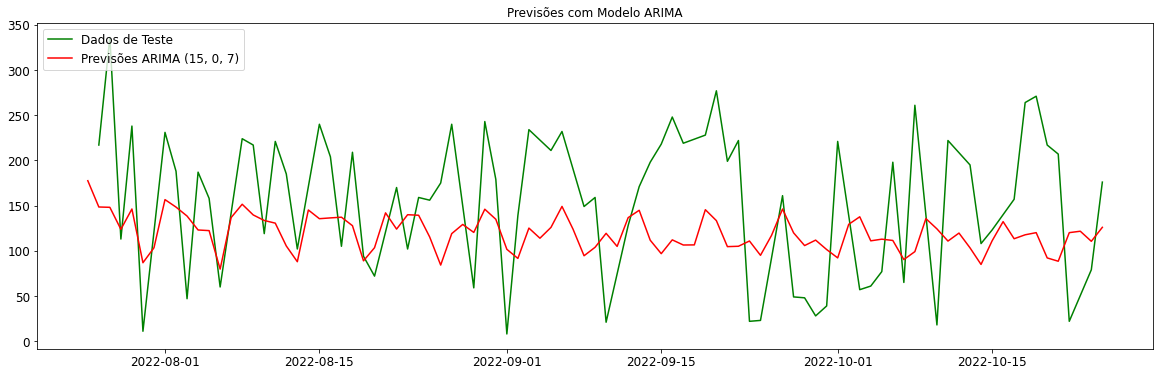

In [193]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (15, 0, 7)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

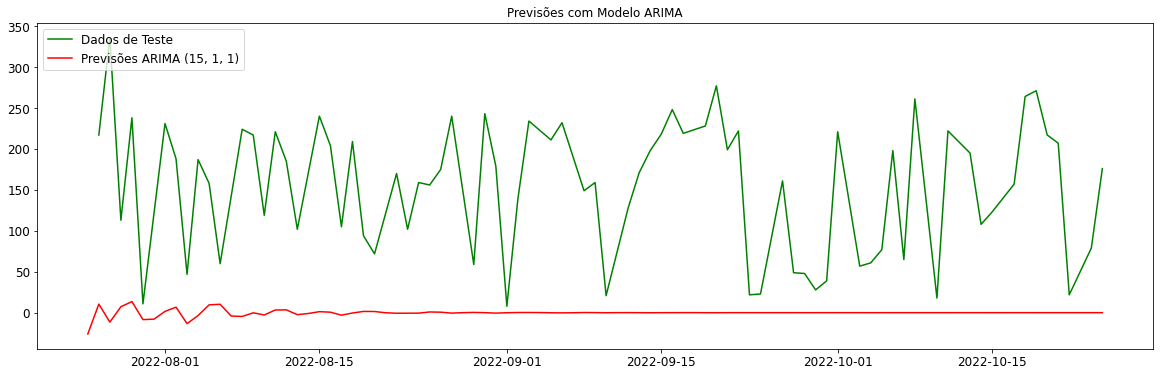

In [211]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (15, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

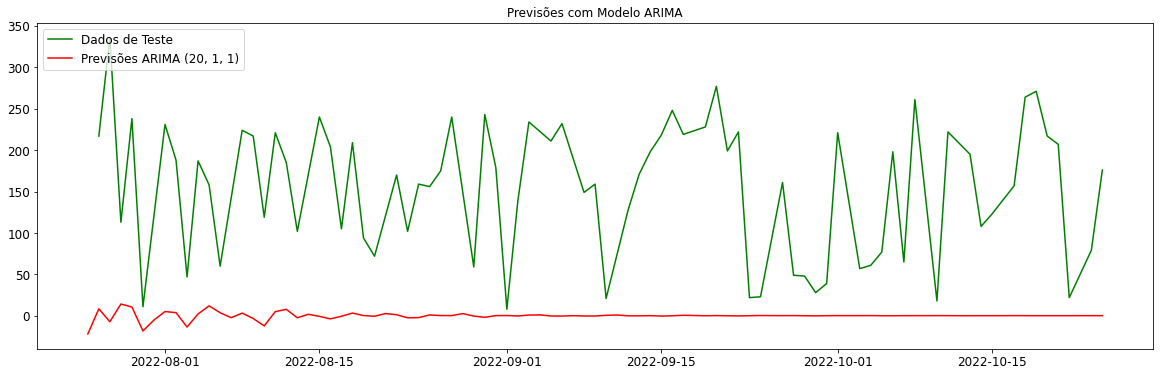

In [121]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (20, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

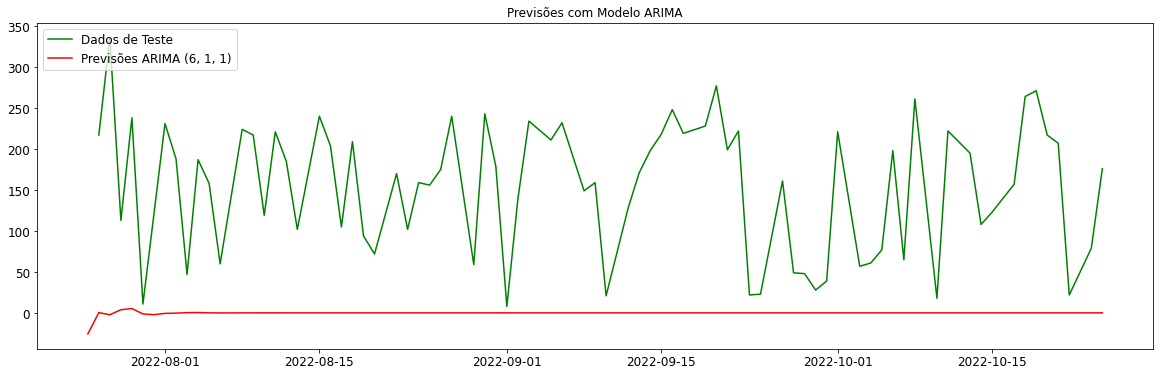

In [97]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (6, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

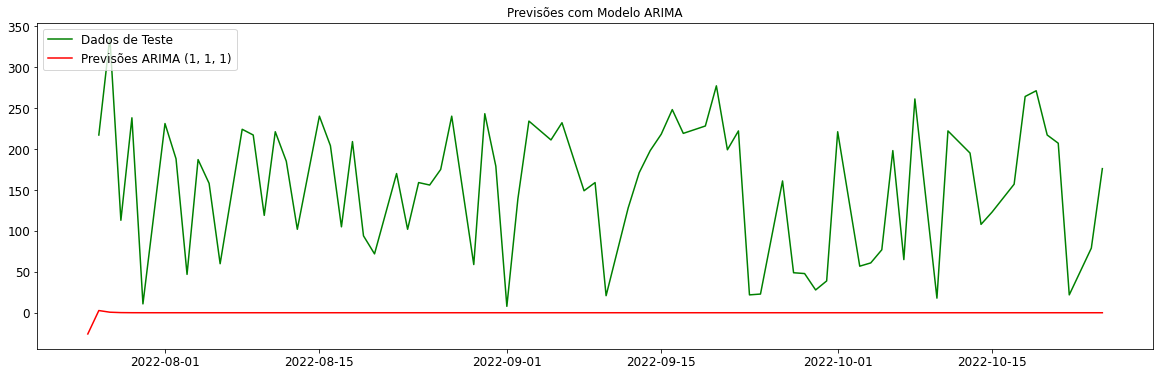

In [79]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (1, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

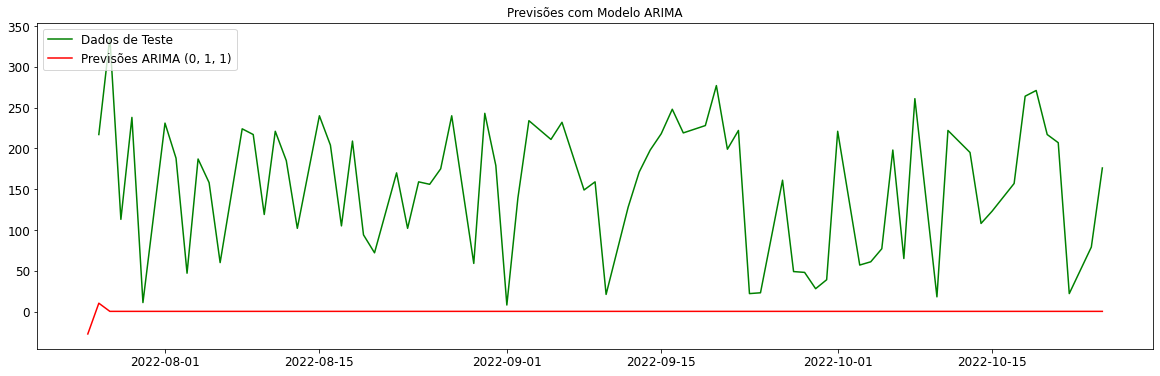

In [60]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (0, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

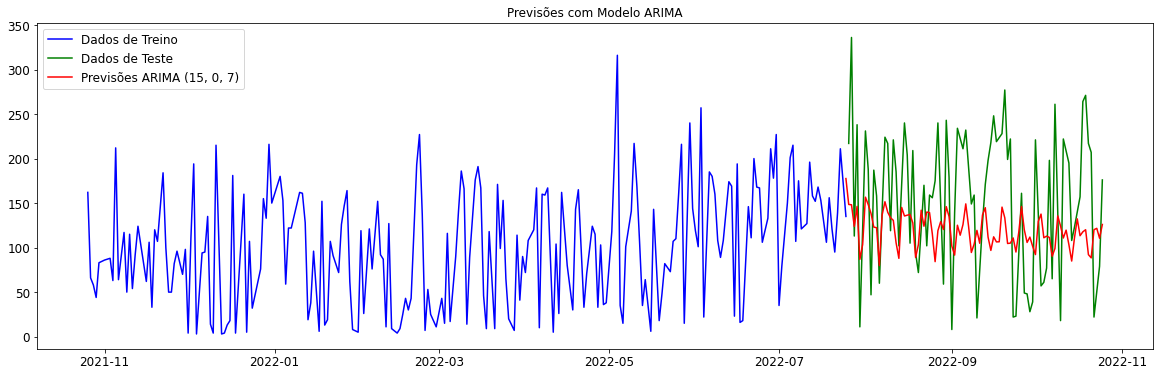

In [194]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (15, 0, 7)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

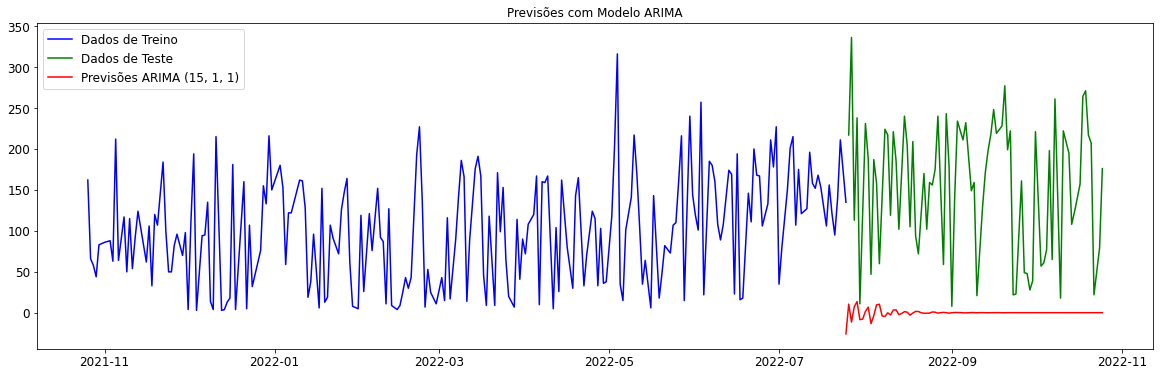

In [212]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (15, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

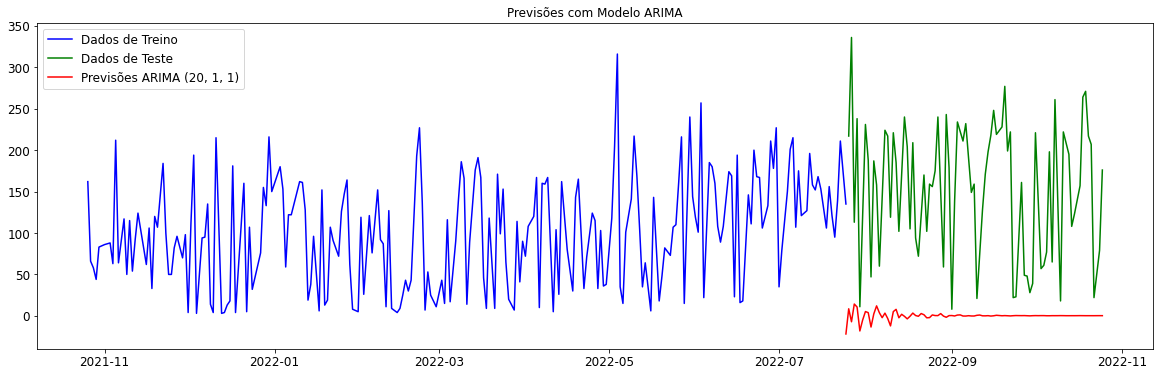

In [122]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (20, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

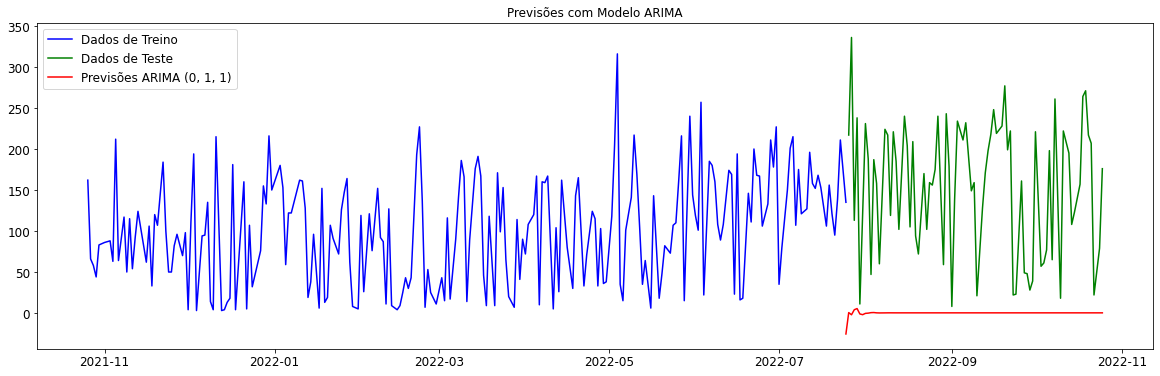

In [98]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (0, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

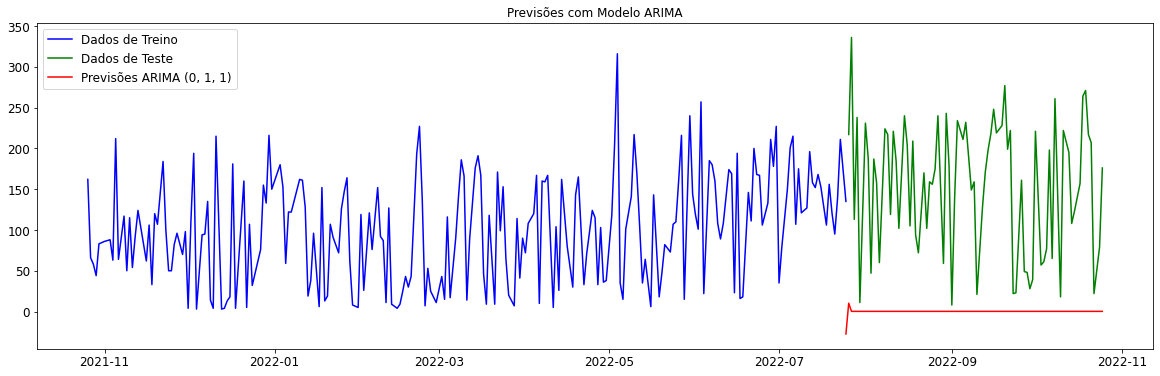

In [61]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (0, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [195]:
# Calculando a performance
arima_results = performance(teste, arima_predict)
#arima_results

MSE das previsões é 6390.653
RMSE das previsões é 79.9416
MAPE das previsões é 87.7052


Vamos executar alguns diagnósticos para avaliar o modelo.

Espera-se que os residos flutuem dentro da média 0 e mesma variância,
sejam estacionários, sem tendência e não sejam auto correlacionados

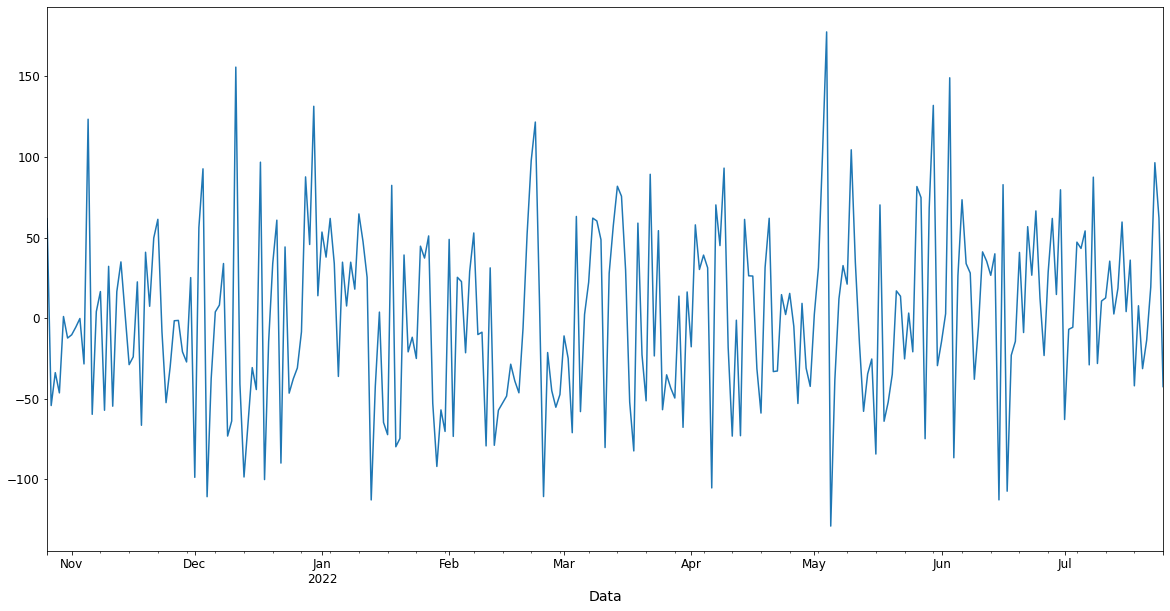

In [196]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

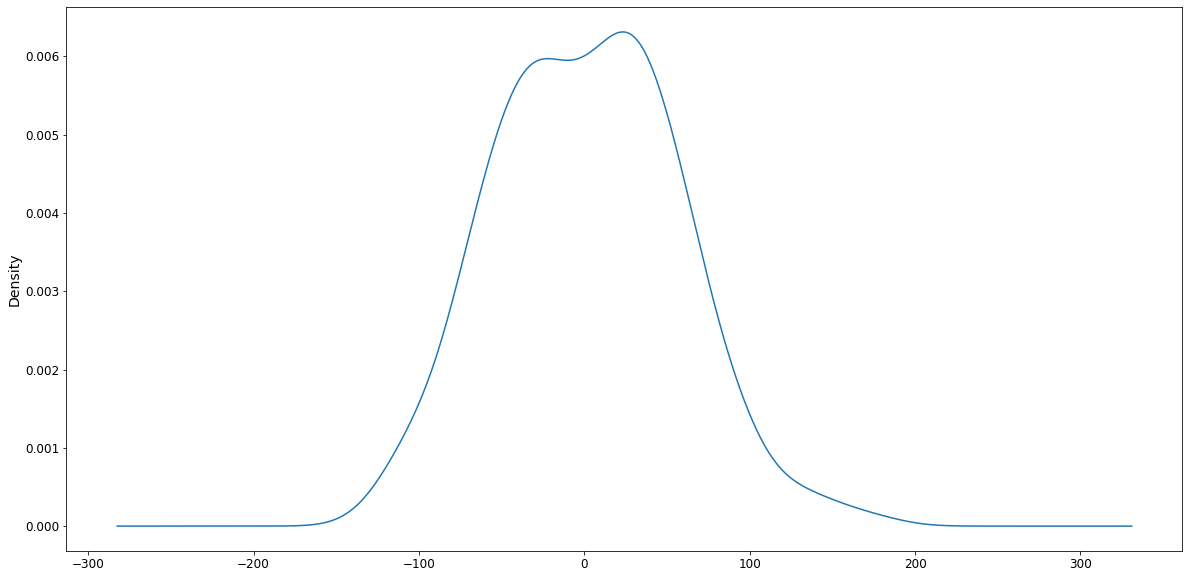

count    273.000000
mean       1.679277
std       55.394876
min     -129.122177
25%      -38.520122
50%        2.542824
75%       39.090714
max      177.622492
dtype: float64


In [197]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [198]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.37598035  -  Os resíduos parecem normalmente distribuídos.


In [199]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.99976095]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto,

um modelo ARIMA (15,0,7) fornece um bom ajuste do modelo.

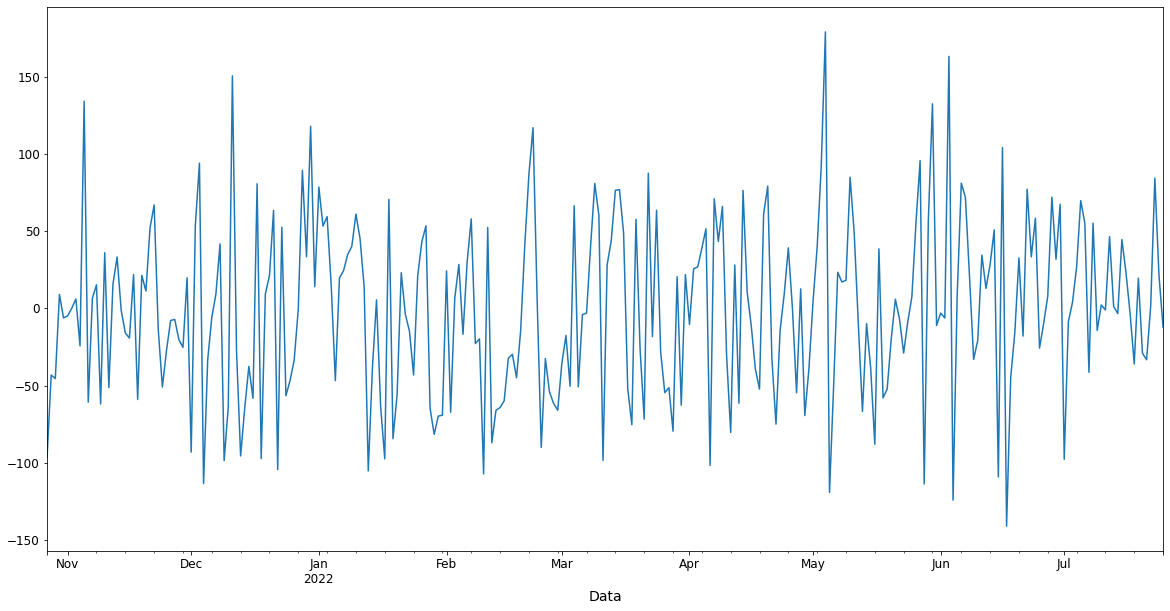

In [161]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

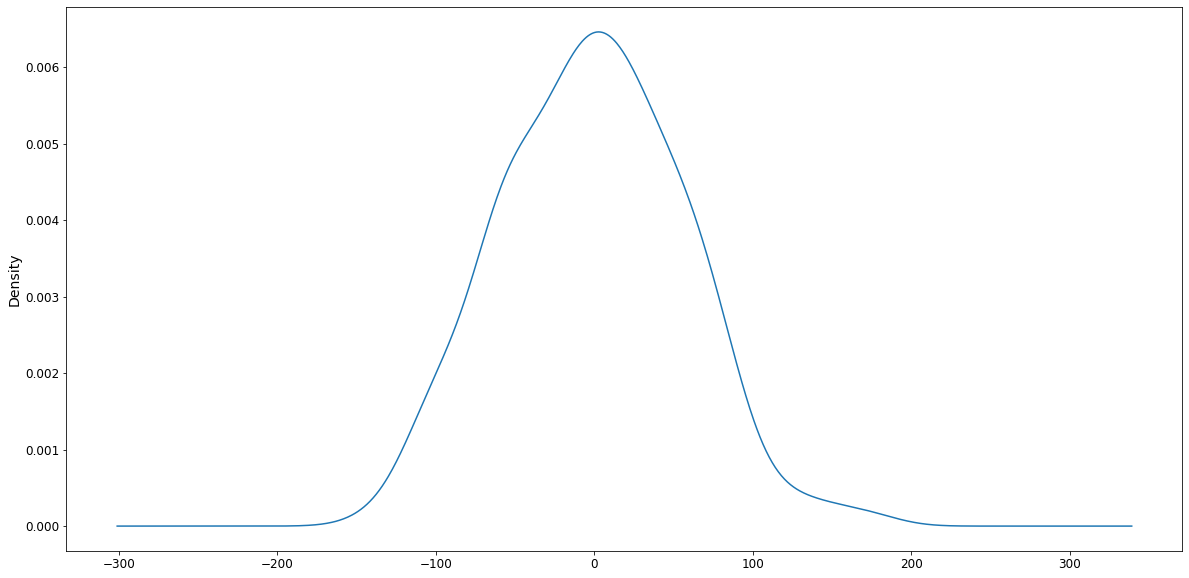

count    272.000000
mean      -1.022151
std       57.184632
min     -140.974966
25%      -43.520611
50%       -1.105633
75%       39.347921
max      179.153337
dtype: float64


In [162]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [163]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.55937150  -  Os resíduos parecem normalmente distribuídos.


In [164]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.9984486]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto,

um modelo ARIMA (15,1,1) fornece um bom ajuste do modelo.

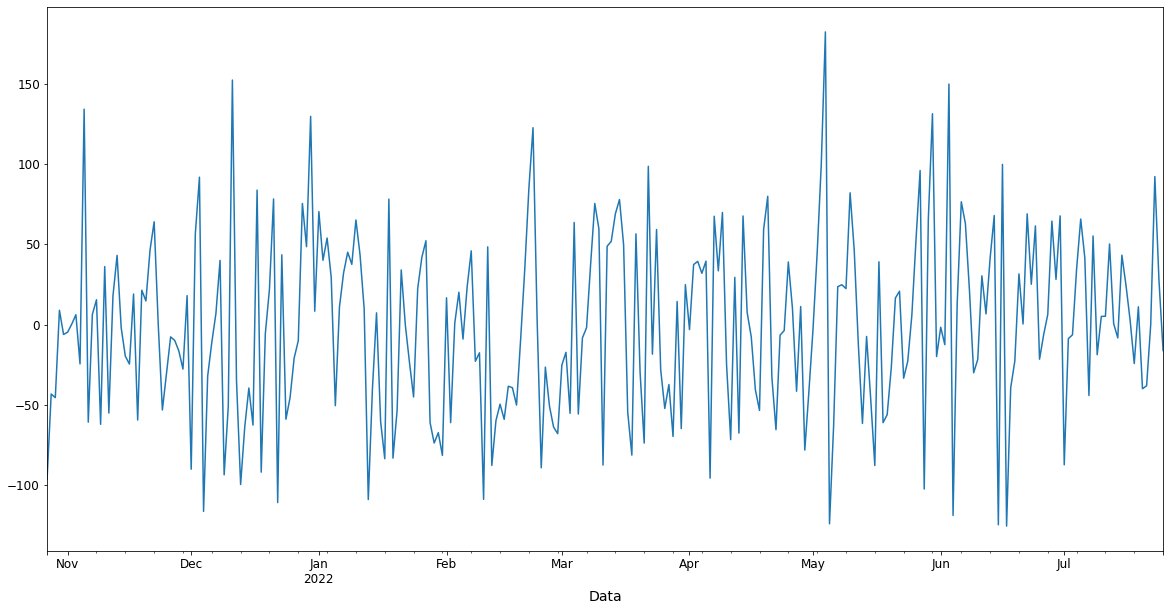

In [123]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

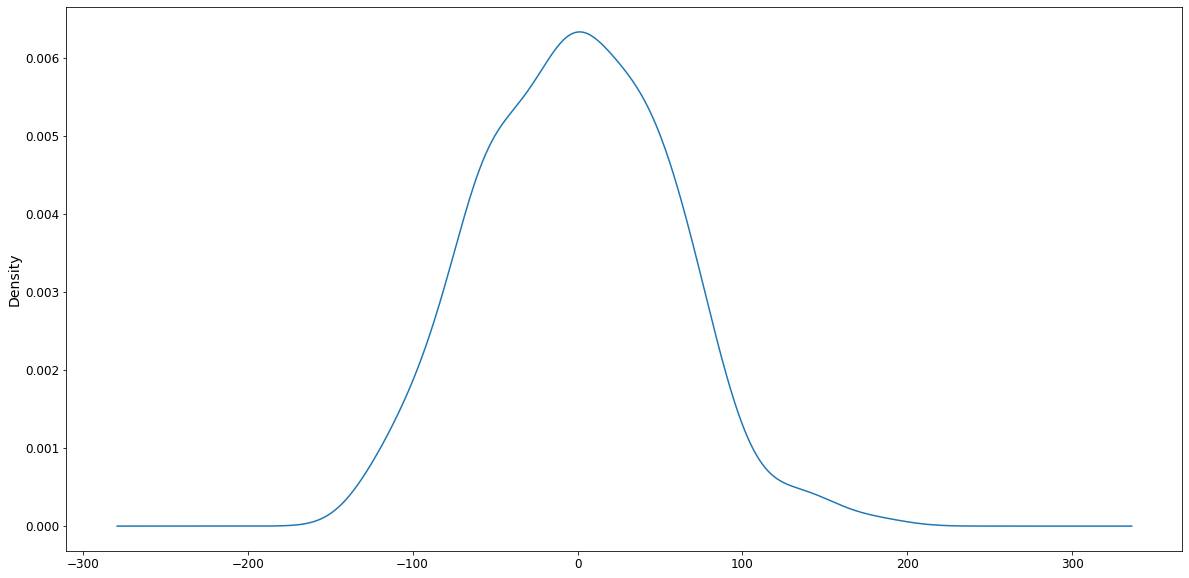

count    272.000000
mean      -0.905746
std       56.737024
min     -125.364711
25%      -43.397612
50%       -0.943050
75%       39.648401
max      182.214990
dtype: float64


In [124]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [125]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.47327950  -  Os resíduos parecem normalmente distribuídos.


In [126]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.99999949]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, 

um modelo ARIMA (20,1,1) fornece um bom ajuste do modelo.

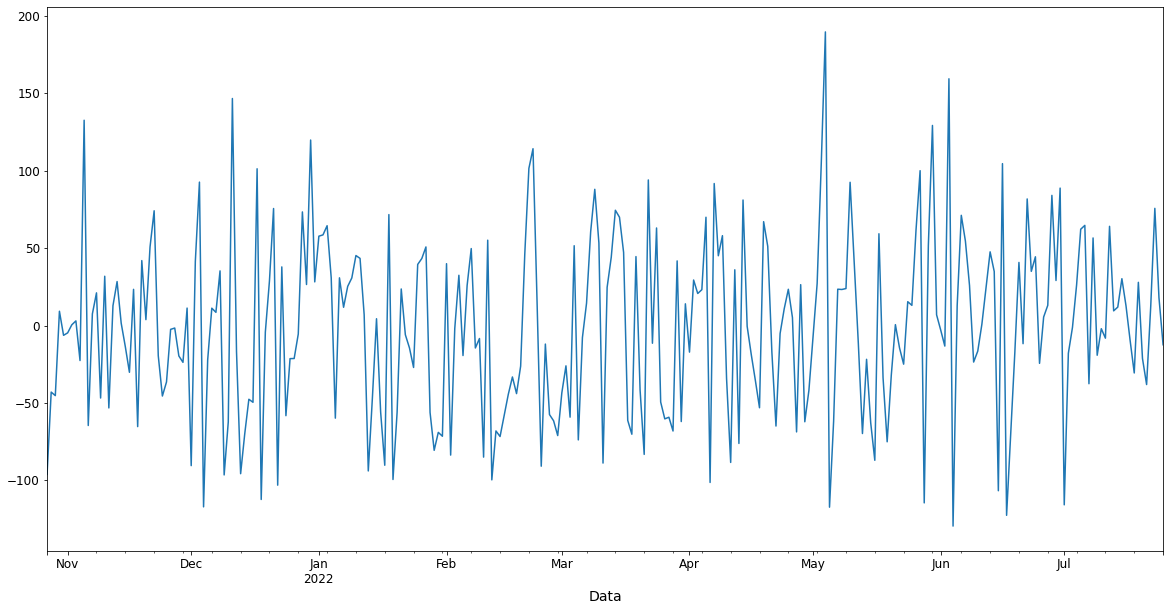

In [99]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

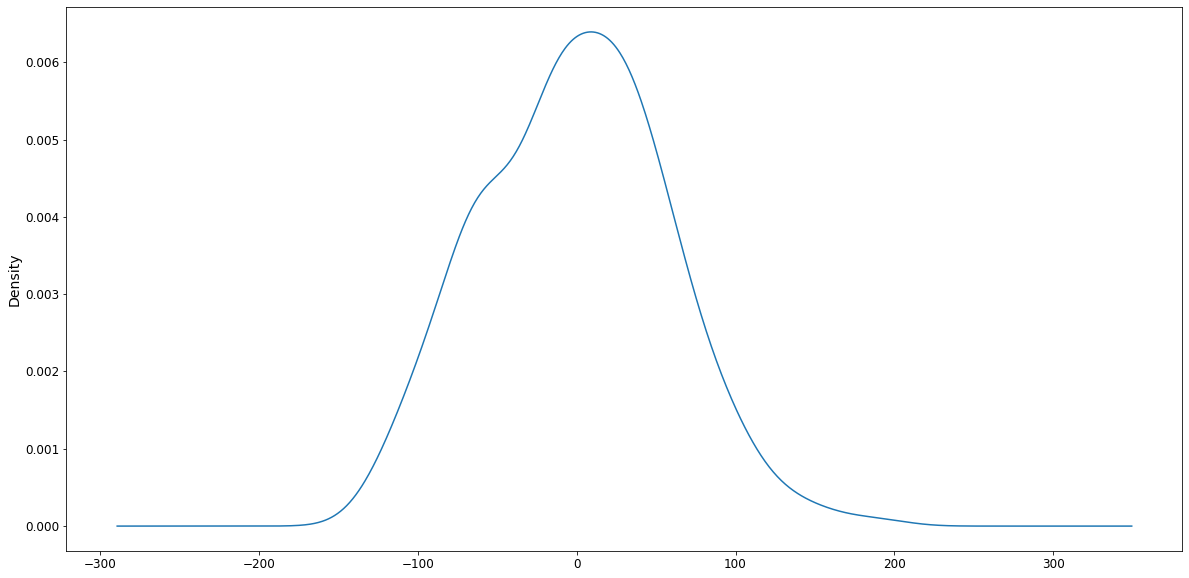

count    272.000000
mean      -1.248955
std       58.147047
min     -129.627383
25%      -45.370730
50%       -0.842035
75%       39.593911
max      189.739359
dtype: float64


In [100]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [101]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.49108594  -  Os resíduos parecem normalmente distribuídos.


In [102]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.84687597]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, 

um modelo ARIMA (6,1,1) fornece um bom ajuste do modelo.

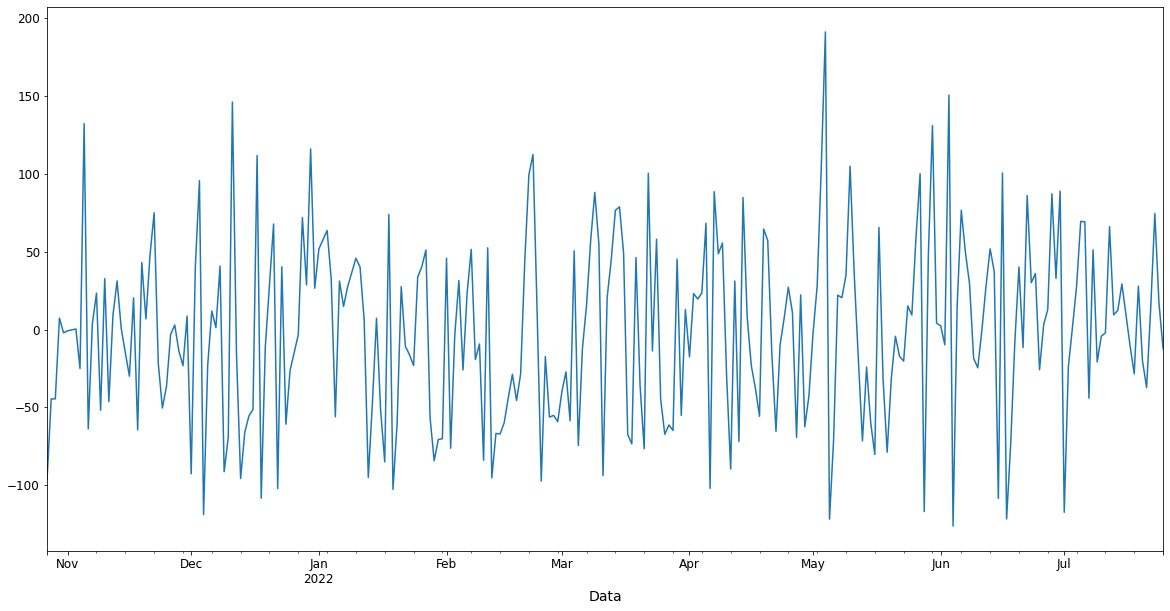

In [80]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

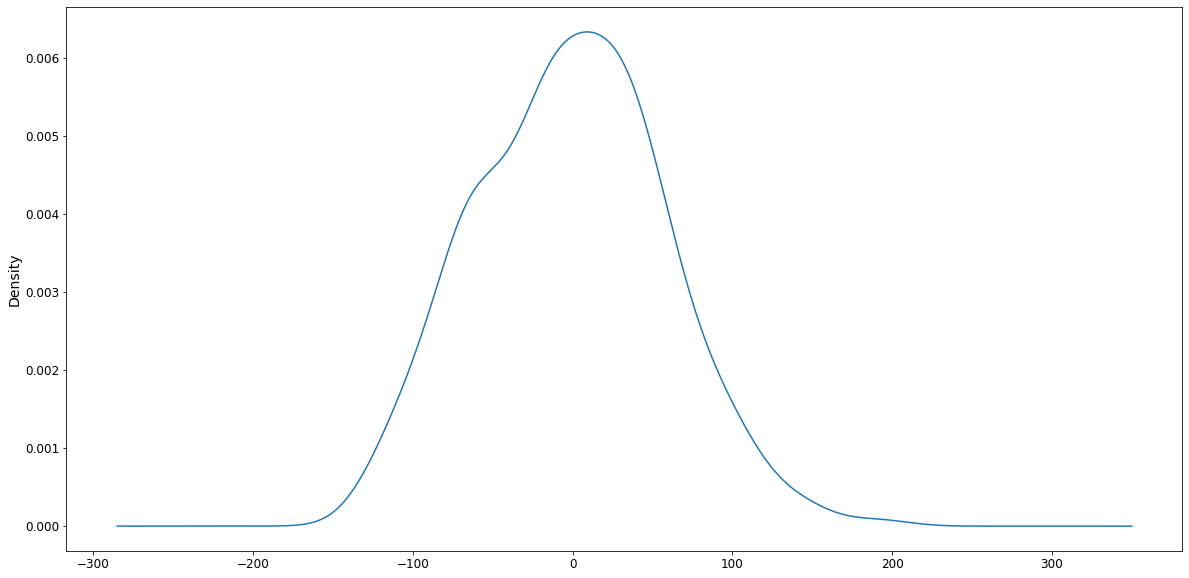

count    272.000000
mean      -1.208848
std       58.284743
min     -126.280551
25%      -44.957395
50%        0.078480
75%       38.054987
max      191.230127
dtype: float64


In [81]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

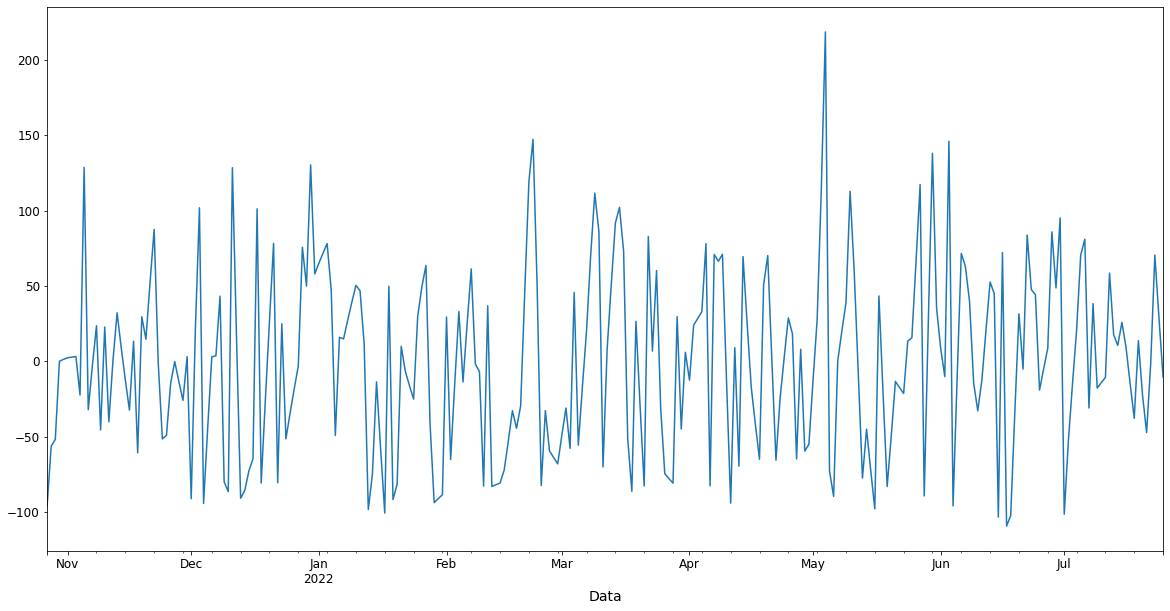

In [63]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

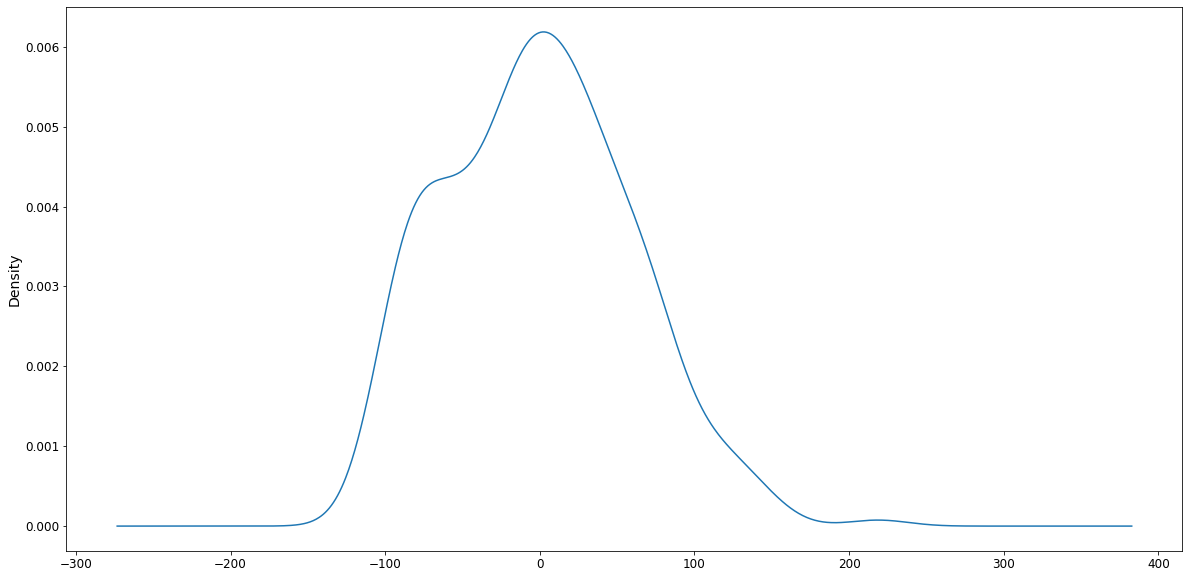

count    272.000000
mean      -0.762027
std       59.959401
min     -109.288358
25%      -49.030848
50%       -0.648992
75%       39.402730
max      218.737575
dtype: float64


In [64]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [82]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.45049579  -  Os resíduos parecem normalmente distribuídos.


In [83]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.76690281]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, 

um modelo ARIMA (1,1,1) fornece um bom ajuste do modelo.

In [65]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.06595780  -  Os resíduos parecem normalmente distribuídos.


In [66]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.02574567]


Observe que o valor-p é menor que 0,05, o que indica que os resíduos não são independentes no nível de 95% e, portanto, 

um modelo ARIMA (0,1,1) não fornece um bom ajuste do modelo.

Como estamos até agora:

- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513

Com o modelo ARIMA conseguimos reduzir o erro total do modelo, embora o AIC tenha aumentado um pouco. O ARIMA Predict não convergiu.

O modelo ARIMA consegue um ajuste aos dados, mas é muito pior que o modelo ARMA.

Vamos ver o que conseguimos com um modelo mais avançado, o SARIMA. Na próxima aula. 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim